# Task 1

Let Y be a RV that a person will use XAI, Y_hat - RV our prediction if will use XAI (if a person is enrolled in training for blues).
Let C be the group (either blue or red).

demografic parity coeff = P(Y_hat = 1 | C = blue) / P(Y_hat = 1 | C = red) = 0.65 / 0.5 = 1.3

equal opportunity coeff = P(Y_hat = 1 | Y = 1, C = blue) / P(Y_hat = 1 | Y = 1, C = red) = 0.75 / 0.5 = 1.5

predictive rate parity coeff = P(Y = 1 | Y_hat = 0, C = blue) / P(Y = 1 | Y_hat = 1, C = red) = 0.92 / 0.5 = 1.84

I would say that the easiest thing to do would be to increase the percentage of Red people allowed to attend XAI training. 
The increase from 50% to 75% (still randomly selected) would let all three disparity coefficients lie in [4/5, 5/4] interval.




# Task 2
We will work with the adult dataset

In [1]:
import dalex as dx
import xgboost

import sklearn
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np


In [2]:
df_in = pd.read_csv('adult.csv')
df_in.head(5)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
df_in.columns[df_in.dtypes == 'category']

Index([], dtype='object')

preprocesing

In [4]:
df = df_in[(df_in != '?').all(axis=1)].drop(columns='fnlwgt')
df.loc[:, df.dtypes == 'object'] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))

X = df.drop(columns='income')
# convert gender to binary only because the `max_cat_to_onehot` parameter in XGBoost is yet to be working properly..
X = pd.get_dummies(X, columns=X.columns[X.dtypes == 'category'], drop_first=True) 
y = df.income == '>50K'
y.name = 'high_income'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# X_train.columns

/tmp/ipykernel_237062/3028133320.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, df.dtypes == 'object'] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))


we use xgboost as a main model

In [5]:
model = xgboost.XGBClassifier(
    n_estimators=50, 
    max_depth=2, 
    use_label_encoder=False, 
    eval_metric="logloss",
    
    enable_categorical=True,
    tree_method="hist"
)

model.fit(X_train, y_train)

/home/quczer/anaconda3/envs/xai/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [6]:
explainer = dx.Explainer(model, X_test, y_test, label='vanilla XGB')

Preparation of a new explainer is initiated

  -> data              : 14924 rows 95 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 14924 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : vanilla XGB
  -> predict function  : <function yhat_proba_default at 0x7ff197704820> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000371, mean = 0.249, max = 0.997
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.954, mean = -0.00156, max = 0.998
  -> model_info        : package xgboost

A new explainer has been created!


In [7]:
explainer.model_performance()


,recall,precision,f1,accuracy,auc
vanilla XGB,0.587486,0.792763,0.67486,0.859957,0.917353


let's pick gender as a protected attribute and compute coefficients

In [8]:
protected_variable = X_test.gender_Male.apply(lambda x: "male" if x else "female")
privileged_group = "male"

fobject = explainer.model_fairness(
    protected=protected_variable,
    privileged=privileged_group
)

In [9]:
def plot(path: str):
    import matplotlib.pyplot as plt
    im = plt.imread(path)
    plt.figure(figsize=(16, 6))
    plt.axis('off')
    plt.imshow(im)
    plt.show()

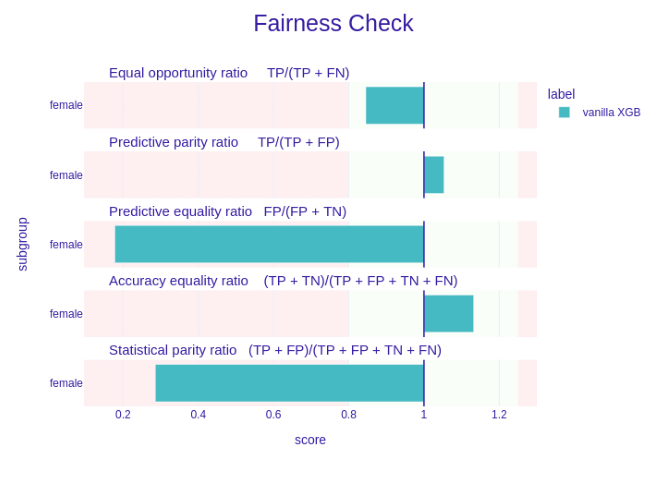

In [10]:
fobject.plot(show=False).write_image(f'vanilla.png')
plot('vanilla.png')

In [11]:
fobject.fairness_check()

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'male'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
             TPR       ACC       PPV       FPR       STP
female  0.845258  1.132121  1.053299  0.178082  0.285714


lets create a stronger model (in terms of expression power)

In [12]:
stronger_model = xgboost.XGBClassifier(
    n_estimators=100, 
    max_depth=6, 
    use_label_encoder=False, 
    eval_metric="logloss",
    
    enable_categorical=True,
    tree_method="hist"
)

stronger_model.fit(X_train, y_train)

/home/quczer/anaconda3/envs/xai/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [13]:
stronger_explainer = dx.Explainer(stronger_model, X_test, y_test, label='vanilla stronger XGB')


Preparation of a new explainer is initiated

  -> data              : 14924 rows 95 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 14924 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : vanilla stronger XGB
  -> predict function  : <function yhat_proba_default at 0x7ff197704820> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 9.32e-06, mean = 0.246, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.998, mean = 0.00121, max = 1.0
  -> model_info        : package xgboost

A new explainer has been created!


In [14]:
stronger_explainer.model_performance()

,recall,precision,f1,accuracy,auc
vanilla stronger XGB,0.658992,0.785092,0.716537,0.871013,0.92849


In [15]:
explainer.model_performance()


,recall,precision,f1,accuracy,auc
vanilla XGB,0.587486,0.792763,0.67486,0.859957,0.917353


Stronger model seems to be doing slightly better. Let's now see how it performs when looked at fairness.

In [16]:
protected_variable = X_test.gender_Male.apply(lambda x: "male" if x else "female")
privileged_group = "male"

stronger_fobject = stronger_explainer.model_fairness(
    protected=protected_variable,
    privileged=privileged_group
)

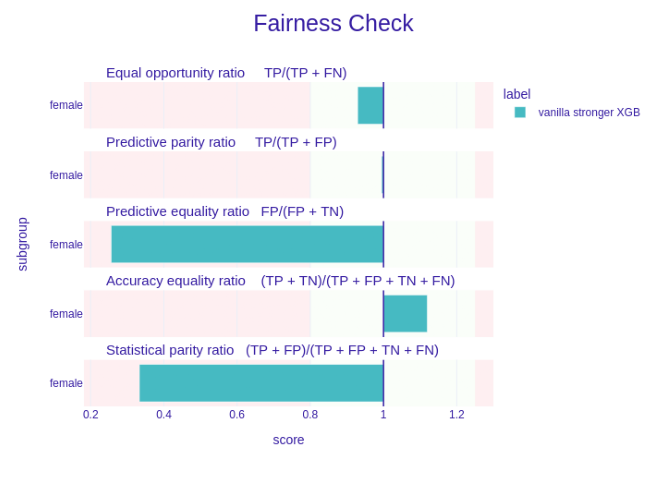

In [17]:
stronger_fobject.plot(show=False).write_image(f'strong_vanilla.png')
plot('strong_vanilla.png')

In [18]:
stronger_fobject.fairness_check()


Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'male'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
             TPR      ACC       PPV       FPR       STP
female  0.929429  1.11919  0.994911  0.256098  0.333333


Stronger model seems to be also better when it comes to fairness, but it is still not quite within our acceptable margins.
Let's try to improve its fairness now via model post_processing. We'll lower the threshold to be classified as a high income for women.

In [19]:
from functools import partial

def fair_predict(
    model: xgboost.XGBClassifier,
    data: pd.DataFrame,
    protected_var: str = "gender_Male",
    privileged_group=1,
    thold: float = 0.6,
) -> pd.Series:
    proba = model.predict_proba(data)
    result = pd.Series(index=data.index)
    idx_privileged = data[protected_var] == privileged_group
    result[idx_privileged == True] = proba[idx_privileged, 1] > 0.5
    result[idx_privileged == False] = proba[~idx_privileged, 1] > thold
    return result.astype(int).values



In [20]:
predict_function = partial(fair_predict, thold= 0.2)
fair_explainer = dx.Explainer(stronger_model, X_test, y_test, predict_function=predict_function, label='fair XGB')


Preparation of a new explainer is initiated

  -> data              : 14924 rows 95 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 14924 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : fair XGB
  -> predict function  : functools.partial(<function fair_predict at 0x7ff1b846db80>, thold=0.2) will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.23, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = 0.017, max = 1.0
  -> model_info        : package xgboost

A new explainer has been created!


/tmp/ipykernel_237062/1615958711.py:11: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/tmp/ipykernel_237062/1615958711.py:11: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [21]:
fair_explainer.model_performance()

,recall,precision,f1,accuracy,auc
fair XGB,0.687974,0.738802,0.712482,0.862637,0.804012


We can see that the fair model performance has dropped in comparison to its unaltered version, but that may be the sacrifice we are willing to take.

In [22]:
sum(model.predict(X_test) != predict_function(model, X_test)) / len(X_test)


/tmp/ipykernel_237062/1615958711.py:11: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



0.032229965156794424

In [23]:
fair_fobject = fair_explainer.model_fairness(
    protected=protected_variable,
    privileged=privileged_group
)

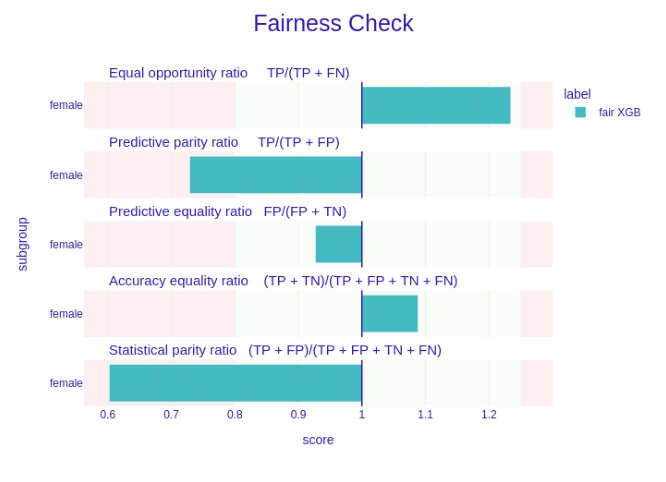

In [24]:
fair_fobject.plot(show=False).write_image(f'fair.png')
plot('fair.png')

In [25]:
fair_fobject.fairness_check()


Bias detected in 2 metrics: PPV, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'male'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
             TPR     ACC       PPV       FPR       STP
female  1.234234  1.0882  0.729008  0.926829  0.602273


Still we can see that we are not fair yet, but it may seem that we made a big step towards overall fairness. 
Right now women have way better opportunity ratio, but within margins (women are in favour now). Statistical parity ratio on the other hand is still worse for women. It may be the case that of the inherent differences in the population we are unable to make it fair from each perspective.

Below I put a plot to compare the three models visually. Beware that the scales differ from chart to chart.

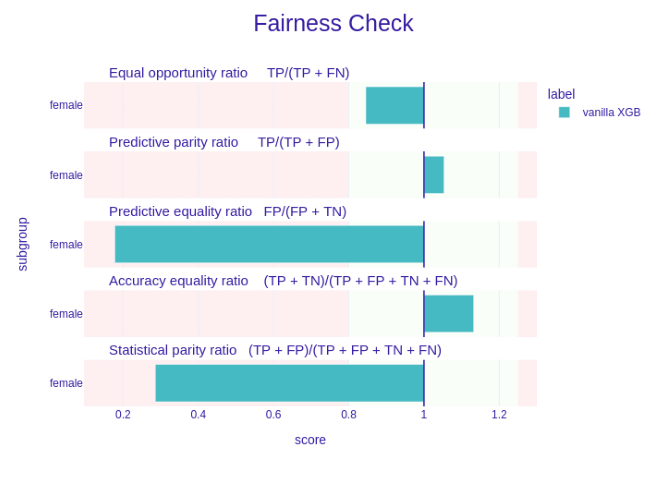

In [26]:
plot('vanilla.png')

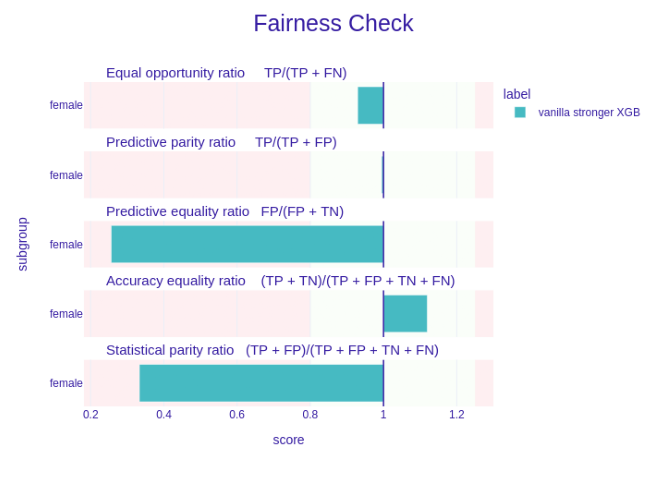

In [27]:
plot('strong_vanilla.png')


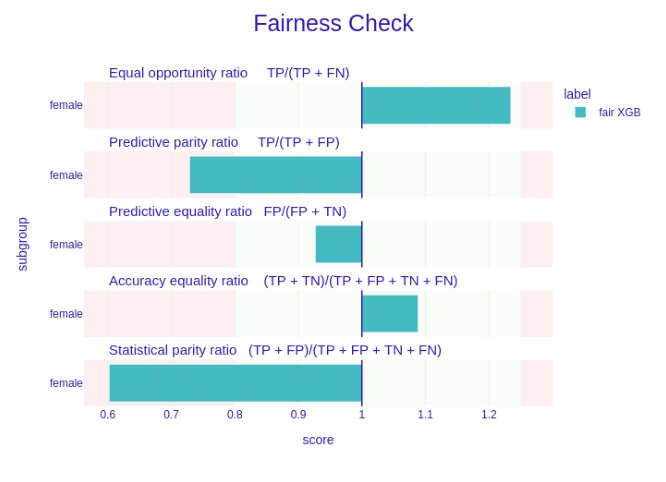

In [28]:
plot('fair.png')

We can see that changing threshold pushes all (except accuracy) fairness checks from left to right.